In [412]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import itertools

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
from scipy.sparse import csgraph
import pandas as pd

import graphsemnet.gsn_recursive as gsn
import graphsemnet.semantics as sem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sns.set(font_scale=1.5)

# Agent-based simulation

In [4]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [340]:
def interp_matrices(x, y, interp):
    return x - (x - y) * interp

In [341]:
class Agent(object):
    def __init__(self, id_string, graph, learning_rate=.2):
        print(f"\"Hello world, I'm {id_string}.\"")
        self.id_string = id_string
        self.graph = graph
        self.learning_rate = learning_rate
        self.episode_graph = None
        
    def start_episode(self):
        print(f"{self.id_string} is listening")
        self.episode_graph = copy.deepcopy(self.graph)
    
    def end_episode(self):
        print(f"{self.id_string} stopped listening")
        self.graph.adj = interp_matrices(self.graph.adj, self.episode_graph.adj, self.learning_rate)
        self.episode_graph = None
    
    def send(self, receivers, words):
        print(f"{self.id_string} says \"{' '.join(words)}\"")
        for receiver in receivers:
            receiver.receive(words)
            
    def receive(self, words):
        print(f"{self.id_string} received {words}")
        if self.episode_graph is None:
            print(f"{self.id_string} wasn't listening")
            return
        for word in words:
            if word not in self.graph.labels:
                print(f"{self.id_string} doesn't know the word \"{word}\"")
        words = [word for word in words if word in self.graph.labels]
        print(f"{self.id_string} updated their episode graph weights")
        self.episode_graph.activate_words(words)
        
    def spontaneous_words(self, n=2):
        assert self.episode_graph is not None
        mean_in = np.mean(self.episode_graph.adj, axis=0)
        dist = make_prob_dist(mean_in)
        return np.random.choice(self.episode_graph.labels, size=n, p=dist, replace=False)

## Mnemonic convergence of two agents

In [349]:
words_a = [
    'income',
    'inequality',
    'wealthy',
    'rich',
    'poor',
    'tax',
    'liberal',
    'conservative'
]
dsm_a = sem.semantic_dsm(words_a, google_news)
graph_a = gsn.SemanticGraph(word_dsm=dsm_a, labels=words_a)

In [350]:
dsm_a_shuffled = copy.copy(dsm_a)
np.random.shuffle(dsm_a_shuffled)
graph_b = gsn.SemanticGraph(word_dsm=dsm_a_shuffled, labels=words_a)

In [351]:
alice = Agent('Alice', graph=copy.deepcopy(graph_a), learning_rate=.5)
bob = Agent('Bob', graph=copy.deepcopy(graph_b), learning_rate=.5)

"Hello world, I'm Alice."
"Hello world, I'm Bob."


In [352]:
alice.start_episode()
bob.start_episode()

Alice is listening
Bob is listening


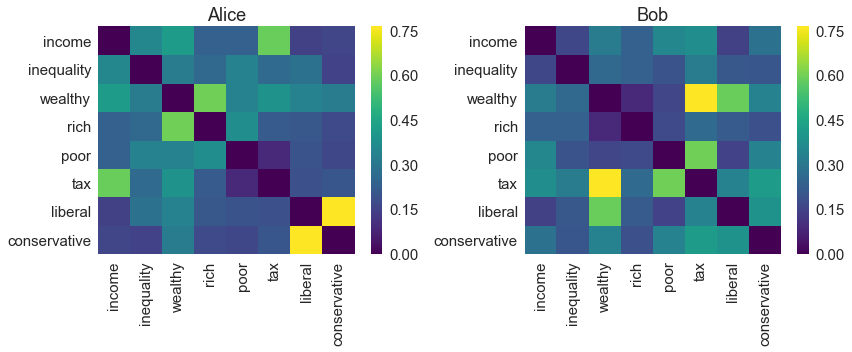

In [353]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(
    alice.episode_graph.adj, 
    xticklabels=alice.episode_graph.labels, 
    yticklabels=alice.episode_graph.labels, 
    cmap='viridis',
    ax=ax1,
)
ax1.set_title('Alice')

sns.heatmap(
    bob.episode_graph.adj, 
    xticklabels=bob.episode_graph.labels, 
    yticklabels=bob.episode_graph.labels, 
    cmap='viridis',
    ax=ax2
)
ax2.set_title('Bob')
plt.tight_layout()

In [354]:
time = []
distance = []

for t in range(25):
    r = dist.correlation(dist.squareform(alice.episode_graph.adj), dist.squareform(bob.episode_graph.adj))
    time.append(t)
    distance.append(r)
    print(f"   - distance(alice, bob): {r}")
    words = alice.spontaneous_words(2)
    alice.send(receivers=[bob], words=words)
    words = bob.spontaneous_words(2)
    bob.send(receivers=[alice], words=words)

   - distance(alice, bob): 0.954668198519975
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9758956221806769
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0871780423577626
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.084892358144146
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their 

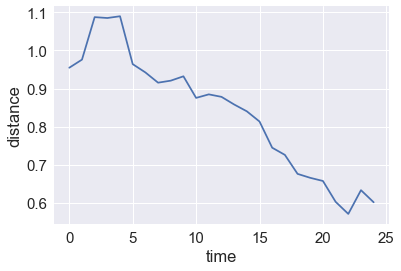

In [355]:
plt.plot(time, distance)
plt.xlabel('time')
plt.ylabel('distance')

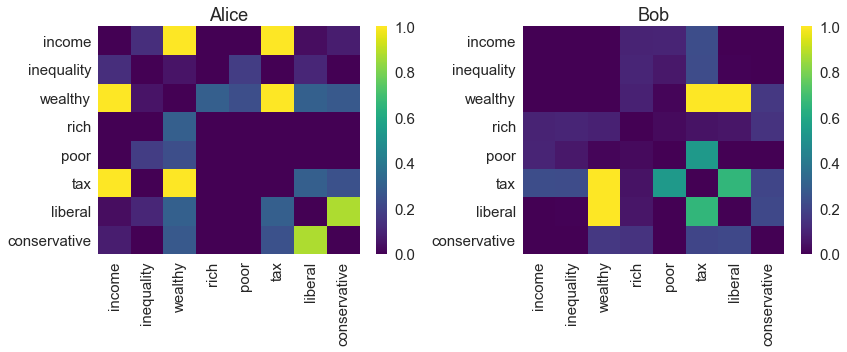

In [356]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(
    alice.episode_graph.adj, 
    xticklabels=alice.episode_graph.labels, 
    yticklabels=alice.episode_graph.labels, 
    cmap='viridis',
    ax=ax1,
)
ax1.set_title('Alice')

sns.heatmap(
    bob.episode_graph.adj, 
    xticklabels=bob.episode_graph.labels, 
    yticklabels=bob.episode_graph.labels, 
    cmap='viridis',
    ax=ax2
)
ax2.set_title('Bob')
plt.tight_layout()

In [357]:
alice.end_episode()
bob.end_episode()

Alice stopped listening
Bob stopped listening


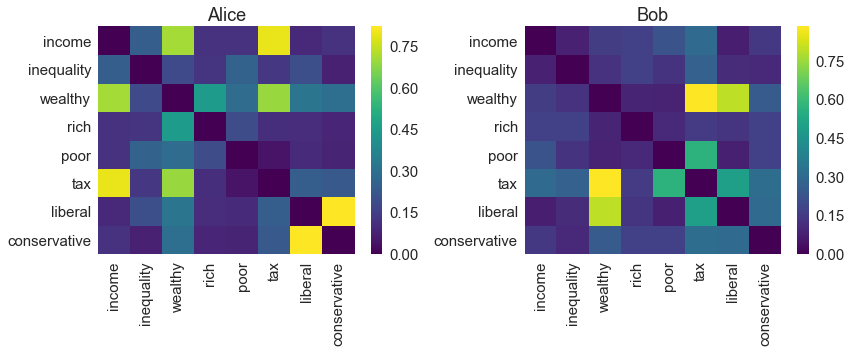

In [358]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(
    alice.graph.adj, 
    xticklabels=alice.graph.labels, 
    yticklabels=alice.graph.labels, 
    cmap='viridis',
    ax=ax1,
)
ax1.set_title('Alice')

sns.heatmap(
    bob.graph.adj, 
    xticklabels=bob.graph.labels, 
    yticklabels=bob.graph.labels, 
    cmap='viridis',
    ax=ax2
)
ax2.set_title('Bob')
plt.tight_layout()

## Network structure

<img src='momennejad_networks.png'>

In [518]:
clustered_adj = np.zeros(shape=(10,10))
clustered_adj[0, (1,2,3)] = 1
clustered_adj[1, (0,2,3)] = 1
clustered_adj[2, (0,1,4)] = 1
clustered_adj[3, (0,1,4)] = 1
clustered_adj[4, (2,3,5)] = 1
clustered_adj[5, (4,6,7)] = 1
clustered_adj[6, (5,8,9)] = 1
clustered_adj[7, (5,8,9)] = 1
clustered_adj[8, (6,7,9)] = 1
clustered_adj[9, (6,7,8)] = 1
print(clustered_adj)

clustered = [
    [
        (0, 2),
        (1, 3),
        (4, 5),
        (7, 9),
        (6, 8)
    ],
    [
        (1, 2),
        (3, 4),
        (5, 7),
        (6, 9)
    ],
    [
        (0, 3),
        (2, 4),
        (5, 6),
        (7, 8)
    ],
    [
        (0, 1),
        (8, 9)
    ]
]

[[ 0.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  0.]]


In [519]:
non_clustered_adj = np.zeros(shape=(10,10))
non_clustered_adj[0, (8,2,3)] = 1
non_clustered_adj[1, (9,2,3)] = 1
non_clustered_adj[2, (0,1,4)] = 1
non_clustered_adj[3, (0,1,4)] = 1
non_clustered_adj[4, (2,3,5)] = 1
non_clustered_adj[5, (4,6,7)] = 1
non_clustered_adj[6, (5,8,9)] = 1
non_clustered_adj[7, (5,8,9)] = 1
non_clustered_adj[8, (6,7,0)] = 1
non_clustered_adj[9, (6,7,1)] = 1
print(non_clustered_adj)

non_clustered = [
    [
        (0, 2),
        (1, 3),
        (4, 5),
        (6, 8),
        (7, 9)
    ],
    [
        (1, 2),
        (3, 4),
        (5, 7),
        (6, 9)
    ],
    [
        (0, 3),
        (2, 4),
        (5, 6),
        (7, 8)
    ],
    [
        (0, 8),
        (1, 9)
    ]
]

[[ 0.  0.  1.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  1.  0.  0.  0.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  0.]]


In [520]:
words_network = [
    'income',
    'inequality',
    'wealthy',
    'rich',
    'poor',
    'tax',
    'liberal',
    'conservative'
]
dsm_network = sem.semantic_dsm(words_network, google_news)

In [537]:
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
agents_clustered = []
agents_non_clustered = []
for name in names:
    new_dsm = copy.copy(dsm_network)
    np.random.shuffle(new_dsm)
    new_graph = gsn.SemanticGraph(word_dsm=new_dsm, labels=words_network)
    new_agent = Agent(name, graph=new_graph, learning_rate=0.4)
    agents_clustered.append(copy.deepcopy(new_agent))
    agents_non_clustered.append(copy.deepcopy(new_agent))

"Hello world, I'm A."
"Hello world, I'm B."
"Hello world, I'm C."
"Hello world, I'm D."
"Hello world, I'm E."
"Hello world, I'm F."
"Hello world, I'm G."
"Hello world, I'm H."
"Hello world, I'm I."
"Hello world, I'm J."


In [538]:
def converse(agent_a, agent_b, n_exchanges=25):
    agent_a.start_episode()
    agent_b.start_episode()
    
    for t in range(n_exchanges):
        words = agent_a.spontaneous_words(2)
        agent_a.send(receivers=[agent_b], words=words)
        words = agent_b.spontaneous_words(2)
        agent_b.send(receivers=[agent_a], words=words)
    
    agent_a.end_episode()
    agent_b.end_episode()

In [539]:
clustered_graph = csgraph.csgraph_from_dense(clustered_adj)
non_clustered_graph = csgraph.csgraph_from_dense(non_clustered_adj)

clustered_shortest_paths = csgraph.shortest_path(clustered_graph)
non_clustered_shortest_paths = csgraph.shortest_path(non_clustered_graph)

In [540]:
def pairwise_distances(agents, shortest_paths):
    distances = []
    binned_distances = {d: [] for d in np.unique(shortest_paths) if d > 0}
    pairs = list(itertools.combinations(range(len(agents)), 2))
    for i, j in pairs:
        agent_a = agents[i]
        agent_b = agents[j]
        d = dist.correlation(
            dist.squareform(agent_a.graph.adj), 
            dist.squareform(agent_b.graph.adj)
        )
        net_d = shortest_paths[i, j]
        binned_distances[net_d].append(d)
    return (distances, binned_distances)

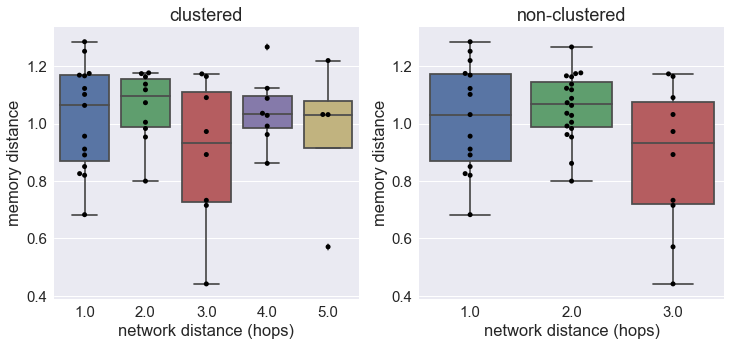

In [543]:
_, clustered_bd = pairwise_distances(agents_clustered, clustered_shortest_paths)
clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clustered_bd.items() ]))

_, non_clustered_bd = pairwise_distances(agents_non_clustered, non_clustered_shortest_paths)
non_clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in non_clustered_bd.items() ]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot(data=pd.DataFrame(clustered_bd_df), ax=ax1)
sns.swarmplot(data=pd.DataFrame(clustered_bd_df), color='black', ax=ax1)
ax1.set_xlabel('network distance (hops)')
ax1.set_ylabel('memory distance')
ax1.set_title('clustered')

sns.boxplot(data=pd.DataFrame(non_clustered_bd_df), ax=ax2)
sns.swarmplot(data=pd.DataFrame(non_clustered_bd_df), color='black', ax=ax2)
ax2.set_xlabel('network distance (hops)')
ax2.set_ylabel('memory distance')
ax2.set_title('non-clustered')

In [544]:
for i, phase in enumerate(clustered):
    print(f"Phase {i}")
    for i, j in phase:
        print(f"{agents_clustered[i].id_string} talks to {agents_clustered[j].id_string}")
        converse(agents_clustered[i], agents_clustered[j], n_exchanges=100)

Phase 0
A talks to C
A is listening
C is listening
A says "conservative rich"
C received ['conservative' 'rich']
C updated their episode graph weights
C says "conservative tax"
A received ['conservative' 'tax']
A updated their episode graph weights
A says "inequality liberal"
C received ['inequality' 'liberal']
C updated their episode graph weights
C says "liberal inequality"
A received ['liberal' 'inequality']
A updated their episode graph weights
A says "tax income"
C received ['tax' 'income']
C updated their episode graph weights
C says "conservative inequality"
A received ['conservative' 'inequality']
A updated their episode graph weights
A says "wealthy tax"
C received ['wealthy' 'tax']
C updated their episode graph weights
C says "inequality income"
A received ['inequality' 'income']
A updated their episode graph weights
A says "liberal poor"
C received ['liberal' 'poor']
C updated their episode graph weights
C says "conservative tax"
A received ['conservative' 'tax']
A updated t

In [545]:
for i, phase in enumerate(non_clustered):
    print(f"Phase {i}")
    for i, j in phase:
        print(f"{agents_non_clustered[i].id_string} talks to {agents_non_clustered[j].id_string}")
        converse(agents_non_clustered[i], agents_non_clustered[j], n_exchanges=100)

Phase 0
A talks to C
A is listening
C is listening
A says "poor liberal"
C received ['poor' 'liberal']
C updated their episode graph weights
C says "rich liberal"
A received ['rich' 'liberal']
A updated their episode graph weights
A says "income inequality"
C received ['income' 'inequality']
C updated their episode graph weights
C says "rich income"
A received ['rich' 'income']
A updated their episode graph weights
A says "conservative inequality"
C received ['conservative' 'inequality']
C updated their episode graph weights
C says "inequality liberal"
A received ['inequality' 'liberal']
A updated their episode graph weights
A says "rich tax"
C received ['rich' 'tax']
C updated their episode graph weights
C says "conservative income"
A received ['conservative' 'income']
A updated their episode graph weights
A says "inequality rich"
C received ['inequality' 'rich']
C updated their episode graph weights
C says "poor wealthy"
A received ['poor' 'wealthy']
A updated their episode graph wei

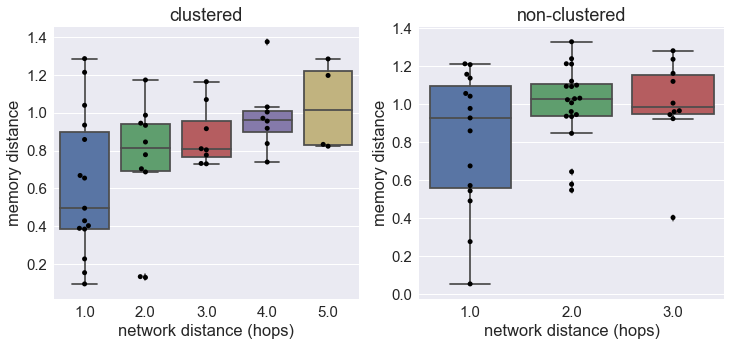

In [546]:
_, clustered_bd = pairwise_distances(agents_clustered, clustered_shortest_paths)
clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clustered_bd.items() ]))

_, non_clustered_bd = pairwise_distances(agents_non_clustered, non_clustered_shortest_paths)
non_clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in non_clustered_bd.items() ]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot(data=pd.DataFrame(clustered_bd_df), ax=ax1)
sns.swarmplot(data=pd.DataFrame(clustered_bd_df), color='black', ax=ax1)
ax1.set_xlabel('network distance (hops)')
ax1.set_ylabel('memory distance')
ax1.set_title('clustered')

sns.boxplot(data=pd.DataFrame(non_clustered_bd_df), ax=ax2)
sns.swarmplot(data=pd.DataFrame(non_clustered_bd_df), color='black', ax=ax2)
ax2.set_xlabel('network distance (hops)')
ax2.set_ylabel('memory distance')
ax2.set_title('non-clustered')

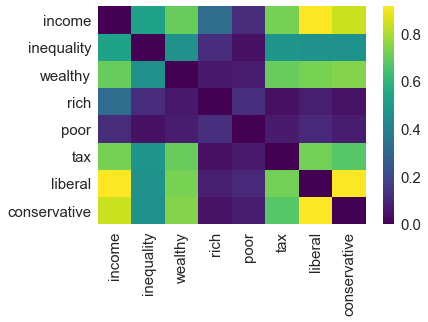

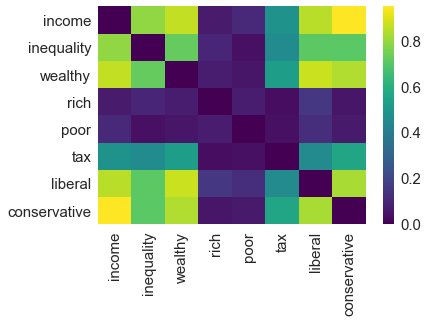

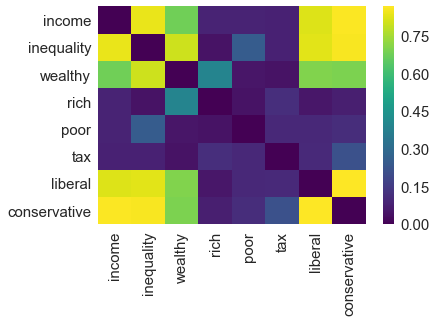

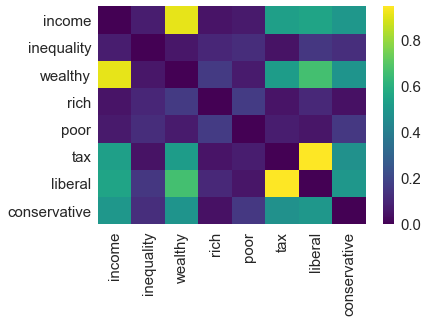

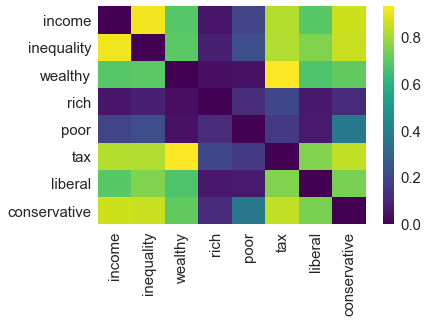

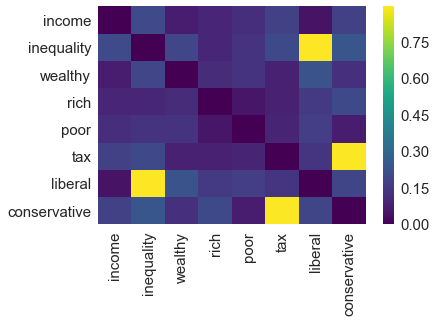

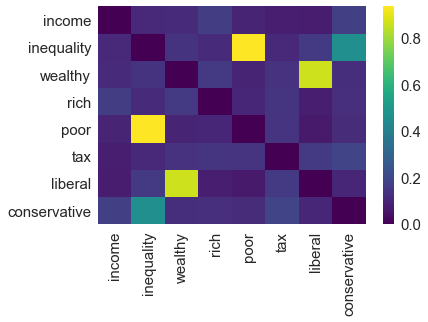

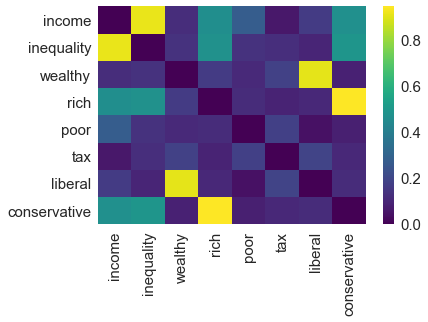

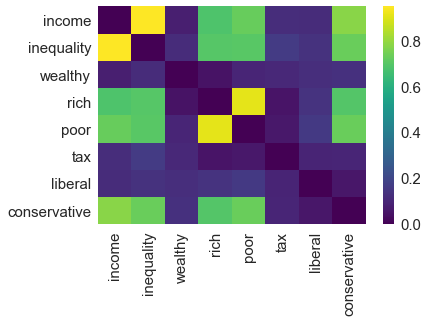

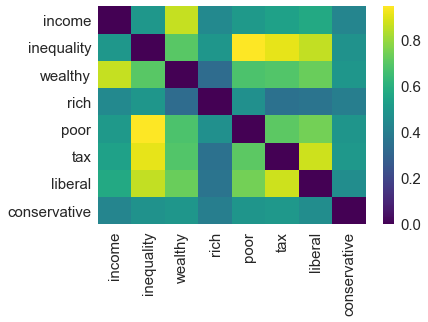

In [548]:
for agent in agents_clustered:
    sns.heatmap(
        agent.graph.adj, 
        xticklabels=agent.graph.labels, 
        yticklabels=agent.graph.labels, 
        cmap='viridis'
    )
    plt.show()